In [84]:
import sys, os, re, copy
import dill as pickle # this serializes all the functions inside the quantification dict
import numpy as np
import scipy as sp
from scipy.optimize import newton, minimize, fsolve
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf
import matplotlib.colors as mcolors
import matplotlib.ticker as ticker
from matplotlib.gridspec import GridSpec
palette = list(mcolors.TABLEAU_COLORS.keys())
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid", {
 'axes.spines.bottom': True,
 'axes.spines.left': True,
 'axes.spines.right': True,
 'axes.spines.top': True
})
sns.set(font_scale=1)
palette = list(mcolors.TABLEAU_COLORS.keys())
sns.set_theme(style="ticks", palette="muted")
sns.set_context("talk")

# Amino acid uptake in 143B GOT DKO cells
hbgdfsa
xdfbgdfsd

In [85]:
AAcode = {
    'Alanine': 'Ala',
    'Arginine': 'Arg',
    'Asparagine': 'Asn',
    'Aspartate': 'Asp',
    'Glutamate': 'Glu',
    'Glutamine': 'Gln',
    'Glycine': 'Gly',
    'Isoleucine': 'Ile',
    'Leucine': 'Leu',
    'Lysine': 'Lys',
    'Methionine': 'Met',
    'Phenylalanine': 'Phe',
    'Proline': 'Pro',
    'Serine': 'Ser',
    'Threonine': 'Thr',
    'Tryptophan': 'Trp',
    'Tyrosine': 'Tyr',
    'Valine': 'Val'
}

In [86]:
def impute_conc(piece_wise_fit_metab, response_ratio):
    '''
    This function imputes the concentration from a response ratio.
    '''
    response_ratio_range = np.array(list(piece_wise_fit_metab.keys()))
    mask_range = [response_ratio >= min_v and response_ratio <= max_v for max_v, min_v in response_ratio_range]
    k = tuple(response_ratio_range[mask_range][0])
    conc = piece_wise_fit_metab[k](response_ratio)
    estimator = 'intrapolation'
    if 0 in k:
        estimator = 'extrapolation under'
    elif np.inf in k:
        estimator = 'extrapolation over'
    return(conc, estimator)

### Calculate quantities and fluxes

In [87]:
### Read quantification function ###
dict_pickle_fnam = 'AA-quant_oct_20.pickle'
with open(dict_pickle_fnam, 'rb') as handle:
    piece_wise_fit_AA = pickle.load(handle)
# Merge the two quantitation dictionaries:
piece_wise_fit_quant = {**piece_wise_fit_AA}

### Read measurements ###
### Replace all N/F with 0 before start ###
esheet_dict_mes = pd.read_excel('Asp-uptake-flux.xlsx', sheet_name=None)
annotation_df = pd.read_excel('annotations.xlsx')
metab_dict_mes = dict()
metab_names_mes = list()
for k in esheet_dict_mes.keys():
    if 'U-13C' not in k:
        metab_names_mes.append(k)
        metab_dict_mes[k] = copy.deepcopy(esheet_dict_mes[k])
        metab_dict_mes[k]['Response Ratio'] = metab_dict_mes[k]['Area'] / metab_dict_mes[k]['ISTD Response']
        metab_dict_mes[k]['Response Ratio'] = metab_dict_mes[k]['Response Ratio'].fillna(0).replace(np.inf, 0)
        # CAA was reconstituted in 400 uL instead of 500 uL
        # CAA peak will then be 5/4 times what it should be
        ## RR will then be 4/5 of what it should be
        # Correction factor: 5/4
        metab_dict_mes[k]['Response Ratio'] = metab_dict_mes[k]['Response Ratio'] * 5/4
        metab_dict_mes[k]['Sample_name'] = [fn.split('_')[-1] for fn in metab_dict_mes[k]['Filename']]
        # Add annotations:
        metab_dict_mes[k] = metab_dict_mes[k].merge(annotation_df, left_on='Sample_name', right_on='Sample_name')
        metab_dict_mes[k] = metab_dict_mes[k].drop(['Flag Details', 'Filename', 'Type', 'RT'], axis=1)

### Impute concentration and add to metabolite dataframe ###
rr_mes = dict() # for plotting 
imp_conc_mes = dict() # for plotting
for metab in metab_names_mes[:]:
    # Assign imputed concentration:
    if metab in piece_wise_fit_quant:
        conc_list = list()
        estimator_list = list()
        for rr in metab_dict_mes[metab]['Response Ratio'].values:
            conc, estimator = impute_conc(piece_wise_fit_quant[metab], rr)
            conc_list.append(conc)
            estimator_list.append(estimator)
        metab_dict_mes[metab]['imputed_sample_conc'] = conc_list
        metab_dict_mes[metab]['imputed_sample_estimator'] = estimator_list

        # Extract data for plotting:
        if metab in rr_mes:
            rr_mes[metab].extend(list(metab_dict_mes[metab]['Response Ratio'].values))
            imp_conc_mes[metab].extend(list(metab_dict_mes[metab]['imputed_sample_conc'].values))
        else:
            rr_mes[metab] = list(metab_dict_mes[metab]['Response Ratio'].values)
            imp_conc_mes[metab] = list(metab_dict_mes[metab]['imputed_sample_conc'].values)

In [88]:
# Convert to media concentration and flux:
for metab in metab_names_mes:
    if metab in piece_wise_fit_quant:
        metab_dict_mes[metab]['undil_sample_conc'] = metab_dict_mes[metab]['imputed_sample_conc'] / metab_dict_mes[metab]['dilution_factor']
        metab_dict_mes[metab]['pmol'] = metab_dict_mes[metab]['undil_sample_conc'] * metab_dict_mes[metab]['Media_vol']
        blank_pmol = metab_dict_mes[metab][metab_dict_mes[metab]['Time'] == 0]['pmol'].mean()
        metab_dict_mes[metab]['nmol_depleted'] = (blank_pmol - metab_dict_mes[metab]['pmol']) * 1e-3
        # Influx in mM/h:
        metab_dict_mes[metab]['Influx'] = metab_dict_mes[metab]['nmol_depleted'] / metab_dict_mes[metab]['vol_hour'] * 1e-6

### Extract all metabolites for quantification ###
df = copy.deepcopy(metab_dict_mes[metab_names_mes[0]]).drop(['Compound', 'Formula', 'Response Ratio', 'Area', 'ISTD Response', 'imputed_sample_conc', 'imputed_sample_estimator', 'undil_sample_conc', 'pmol', 'nmol_depleted', 'Influx', 'dilution_factor', 'vol_hour', 'Media_vol'], axis=1)
for metab in metab_names_mes:
    if metab in piece_wise_fit_quant:
        assert(metab_dict_mes[metab]['Sample_name'].equals(df['Sample_name']))
        df[metab] = metab_dict_mes[metab]['Influx']
# Save data in Excel file:
df.to_excel('influx.xlsx', index=False)

In [ ]:
df

### Plot data

In [91]:
# Rename to three letter amino acid code,
# Sort according to highest influx at 23 h
df.columns = [v.split()[0] for v in df.columns.values]
df = df.rename(columns=AAcode)
# Sort:
df_mean = df.groupby(['Time']).mean().reset_index()
col_sele = df_mean.columns.values[1:]
sort_mask = df_mean.loc[1, col_sele].sort_values(ascending=False).index.values
sort_mask = np.concatenate([['Time'], sort_mask])
df_sort = df.loc[:, sort_mask]
# Remove t=0:
time_mask = df_sort['Time'] > 0
df_sort = df_sort[time_mask]
# Flatten for plotting:
df_melt = df_sort.melt(id_vars=['Time'], var_name='Amino acid', value_name='Flux')

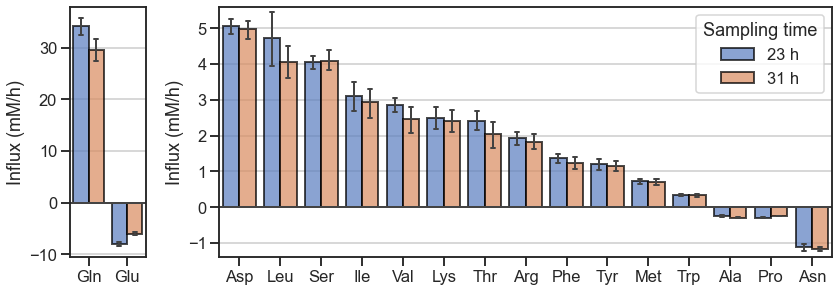

In [96]:
### Plot the influx ###
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4.4), gridspec_kw={'width_ratios': [1, 8]})

# Small plot for Gln/Glu:
mask = df_melt['Amino acid'].isin(['Gln', 'Glu'])
g1 = sns.barplot(ax=ax1, x="Amino acid", y="Flux", hue="Time", data=df_melt[mask], capsize=.1, errwidth=2, edgecolor='black', linewidth=2, alpha=0.7)
ax1.axhline(y=0, linestyle='-', zorder=1, linewidth=2, color='#444444')
g1.grid(True, axis='y')
#g1.set_yscale('log')
g1.set_ylabel('Influx (mM/h)');
g1.set_xlabel('');
g1.legend_.remove()
g1.set_xticklabels(g1.get_xticklabels(), rotation=0)

# Plot the all other AAs:
g2 = sns.barplot(ax=ax2, x="Amino acid", y="Flux", hue="Time", data=df_melt[~mask], capsize=.1, errwidth=2, edgecolor='black', linewidth=2, alpha=0.7)
ax2.axhline(y=0, linestyle='-', zorder=1, linewidth=2, color='#444444')
g2.grid(True, axis='y')
g2.set_ylabel('Influx (mM/h)');
g2.set_xlabel('');
g2.set_xticklabels(g2.get_xticklabels(), rotation=0);
g2.set_ylim([-1.4, 5.6])
g2.yaxis.set_major_locator(ticker.MultipleLocator(1))

# Add legend:
old_legend = g2.legend_
handles = old_legend.legendHandles
labels = ['23 h', '31 h']
title = 'Sampling time'
g2.legend(handles, labels, title=title);

# Show/save:
fig.tight_layout()
fig.savefig('influx.pdf')